In [1]:
import pickle
import lda
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re
import string
import datetime

In [2]:
with open("hillary.pkl.bak", "rb") as f:
    ht = pickle.load(f)

with open("donald.pkl.bak", "rb") as f:
    dt = pickle.load(f)
    
cutoff_date = datetime.datetime(2016,5, 1)
ht = [h for h in ht if h.created_at > cutoff_date]
dt = [d for d in dt if d.created_at > cutoff_date]

In [5]:
tb = TextBlob(ht[0].text)

In [7]:
tb.sentiment

Sentiment(polarity=0.11666666666666668, subjectivity=0.3833333333333333)

In [3]:
ht_time = []
ht_polarity = []
ht_subjectivity = []
for t in ht:
    tb = TextBlob(t.text).sentiment
    ht_time.append(t.created_at)
    ht_polarity.append(tb.polarity)
    ht_subjectivity.append(tb.subjectivity)
    

In [8]:
dt_time = []
dt_polarity = []
dt_subjectivity = []
for t in dt:
    tb = TextBlob(t.text).sentiment
    dt_time.append(t.created_at)
    dt_polarity.append(tb.polarity)
    dt_subjectivity.append(tb.subjectivity)
    

### Polarity

In [9]:
hdf = pd.DataFrame({"polarity":ht_polarity, "subjectivity":ht_subjectivity},index=ht_time)
ddf = pd.DataFrame({"polarity":dt_polarity, "subjectivity":dt_subjectivity},index=dt_time)

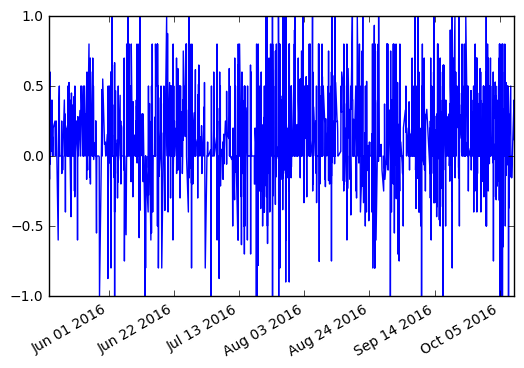

In [10]:
hdf["polarity"].plot()

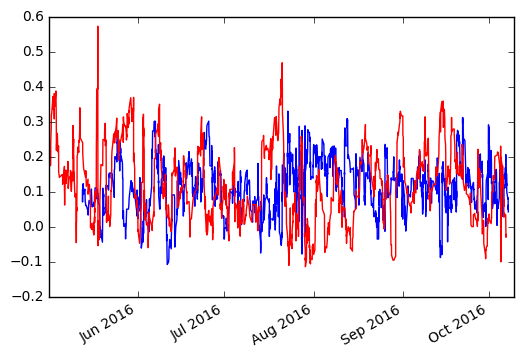

In [14]:
window = 20
ax = hdf.rolling(window).mean()["polarity"].plot()
ddf.rolling(window).mean()["polarity"].plot(style="r",ax=ax)

### Subjectivity

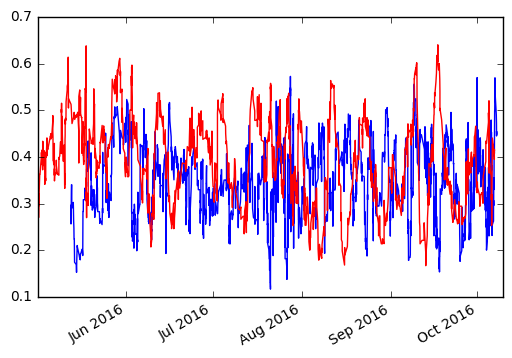

In [15]:
window = 20
ax = hdf.rolling(window).mean()["subjectivity"].plot()
ddf.rolling(window).mean()["subjectivity"].plot(style="r",ax=ax)

## Tweet Tokenize

In [16]:
from nltk.tokenize import word_tokenize, TweetTokenizer

In [17]:
tweet = 'RT @marcobonzanini: just an example! :D http://example.com #NLP'
print word_tokenize(tweet) 

['RT', '@', 'marcobonzanini', ':', 'just', 'an', 'example', '!', ':', 'D', 'http', ':', '//example.com', '#', 'NLP']


In [18]:
tweet_tokenizer = TweetTokenizer()

In [19]:
print tweet_tokenizer.tokenize(tweet)

[u'RT', u'@marcobonzanini', u':', u'just', u'an', u'example', u'!', u':D', u'http://example.com', u'#NLP']


## Term Frequency

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet 

In [21]:
stop_words = stopwords.words("english")+list(string.punctuation)
tweet_stop_words = set(stop_words + ["AT_USER", "URL", "rt", "RT", "..."])
lemmatizer = WordNetLemmatizer()
tag_map = {'NN':wordnet.NOUN,'JJ':wordnet.ADJ,'VB':wordnet.VERB,'RB':wordnet.ADV}


def process_tweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    #escape unicode
    #tweet.encode('ascii', 'ignore')
    tweet = ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    return tweet

def remove_stopwords_lemmatize(tweet_words,lemmatizer):
    lemma = lemmatizer.lemmatize
    return [lemma(w, pos=tag_map.get(pos[:2],'n')) for w,pos in pos_tag(tweet_words) if w not in tweet_stop_words]

In [22]:
def get_words_in_tweets(tweets):
    all_words = []
    for t in tweets:
        tweet = process_tweet(t)
        words = remove_stopwords_lemmatize(tweet_tokenizer.tokenize(tweet), lemmatizer)
        all_words.extend(words)
    return all_words

In [23]:
process_tweet(tweet)

'rt AT_USER just an example! :d URL nlp'

In [24]:
tweet_tokenizer.tokenize(process_tweet(tweet))

[u'rt', u'AT_USER', u'just', u'an', u'example', u'!', u':d', u'URL', u'nlp']

In [25]:
remove_stopwords_lemmatize(tweet_tokenizer.tokenize(process_tweet(tweet)),
                          lemmatizer)

[u'example', u':d', u'nlp']

### Hillary vs Donald Tweets

In [26]:
import nltk

In [27]:
ht_words = get_words_in_tweets( (t.text for t in ht)  )
dt_words = get_words_in_tweets( (t.text for t in dt) )

In [28]:
ht_freqdist = nltk.FreqDist(ht_words)
dt_freqdist = nltk.FreqDist(dt_words)

In [29]:
ht_freqdist.most_common(25)

[(u'trump', 820),
 (u'hillary', 682),
 (u'donald', 439),
 (u'make', 325),
 (u'president', 290),
 (u'american', 230),
 (u'get', 210),
 (u'america', 200),
 (u'u', 194),
 (u'say', 193),
 (u'people', 191),
 (u'family', 185),
 (u'one', 180),
 (u'woman', 167),
 (u'go', 157),
 (u"trump's", 152),
 (u'work', 149),
 (u'need', 143),
 (u'know', 129),
 (u'vote', 128),
 (u'take', 128),
 (u'country', 126),
 (u'plan', 125),
 (u'like', 123),
 (u'tax', 122)]

In [30]:
dt_freqdist.most_common(25)

[(u'hillary', 310),
 (u'thank', 269),
 (u'great', 239),
 (u'trump', 235),
 (u'clinton', 180),
 (u'make', 135),
 (u'2016', 121),
 (u'crook', 120),
 (u'people', 117),
 (u'say', 109),
 (u'america', 107),
 (u'get', 103),
 (u'job', 95),
 (u'bad', 94),
 (u'go', 94),
 (u'join', 92),
 (u'u', 83),
 (u'makeamericagreatagain', 82),
 (u'president', 79),
 (u'americafirst', 73),
 (u'vote', 72),
 (u'want', 69),
 (u'medium', 68),
 (u'today', 68),
 (u'poll', 67)]

## Topic Learning

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tag import pos_tag

In [32]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
    print
    
def tokenizer_lemmatize(doc):
    words = tweet_tokenizer.tokenize(doc)
    return [lemmatizer.lemmatize(w,pos=tag_map.get(pos[:2],'n')) for w,pos in pos_tag(words)]

def top_features(vectorizer, top_n=25):
    # http://stackoverflow.com/questions/25217510/how-to-see-top-n-entries-of-term-document-matrix-after-tfidf-in-scikit-learn
    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()
    top_features = [features[i] for i in indices[:top_n]]
    print top_features

def topic_tweets(doc_matrix, topic_vector,tweets,n_tweets=10):
    overlap = doc_matrix.dot(topic_vector)
    idx = overlap.argsort()[-n_tweets:][::-1]
    for i, t in enumerate(idx):
        print i, tweets[t].text
        print "---"
        
    
#tokenizer = tweet_tokenizer.tokenize
tokenizer = tokenizer_lemmatize

In [33]:
h_tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2,max_features=n_features,
    stop_words=tweet_stop_words, tokenizer=tokenizer,
    preprocessor=process_tweet)

h_tfidf = h_tfidf_vectorizer.fit_transform( (t.text for t in ht) )

In [34]:
h_tfidf

<3220x1000 sparse matrix of type '<type 'numpy.float64'>'
	with 23780 stored elements in Compressed Sparse Row format>

In [35]:
h_nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(h_tfidf)

h_tfidf_feature_names = h_tfidf_vectorizer.get_feature_names()
print_top_words(h_nmf, h_tfidf_feature_names, n_top_words)

Topic #0:
trump donald penny mike campaign rncincle business think it's america
Topic #1:
hillary clinton watch live take tune speak campaign know demsinphilly
Topic #2:
president state united next woman endorse become man clinton never
Topic #3:
make america sure great history go college easy chip let
Topic #4:
tax trump's pay plan family would cut million return release
Topic #5:
u together strong america always let know country stand hate
Topic #6:
vote register right sure you're get today boo woman http
Topic #7:
de la el que los en para n un por
Topic #8:
people american get work need one good every family country
Topic #9:
say thing word don't fix vpdebate want run rncincle go



- Topic 0: Attack on Trump
- Topic 3: Endorsements
- Topic 4: Attack on Trump tax plan
- Topic 6: Spanish tweets
- Topic 7: Targeting women vote



### Donald's Topics

In [36]:
d_tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2,max_features=n_features,
    stop_words=tweet_stop_words, tokenizer=tokenizer,
    preprocessor=process_tweet)

d_tfidf = d_tfidf_vectorizer.fit_transform( (t.text for t in dt) )

In [37]:
d_nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(d_tfidf)
d_tfidf_feature_names = d_tfidf_vectorizer.get_feature_names()
print_top_words(d_nmf, d_tfidf_feature_names, n_top_words)

Topic #0:
thank maga poll new soon americafirst support florida ohio see
Topic #1:
great america make safe job together go poll vote new
Topic #2:
trump 2016 donald votetrump indiana california vote new debate americafirst
Topic #3:
hillary clinton crook bad say crooked bernie president want people
Topic #4:
enjoy interview tonight p 7:00 8p 7pm 7:30 8: 10pme
Topic #5:
makeamericagreatagain together florida imwithyou virginia california today nebraska pennsylvania new
Topic #6:
imwithyou americafirst video support rncincle poll safe arizona result makeamericasafeagain
Topic #7:
join ticket tomorrow maga movement 7pm today pm u ohio
Topic #8:
16 trumppence rncincle soon 11/8 get vote back nomination november
Topic #9:
crookedhillary job lie delete pennsylvania florida benghazi ohio use family



- Topic 0: Links on MakeAmericaGreatAgain
- Topic 1: Negativity on Clinton
- Topic 9: Negativity on Clinton with CrookedHillary hashtag

### Getting Relavant Tweets

In [48]:
topic_id = 4
n_tweets=50
# hillary
#topic_tweets(h_tfidf, h_nmf.components_[topic_id],ht,n_tweets)
# donald
topic_tweets(d_tfidf, d_nmf.components_[topic_id],dt,n_tweets)

0 I will be interviewed on @oreillyfactor tonight at 11pmE @FoxNews. Enjoy!
---
1 I will be interviewed by @oreillyfactor tonight on @FoxNews at 11pm. Enjoy!
---
2 I will be interviewed on @Morning_Joe at 6:15 A.M. Enjoy!
---
3 I will be interviewed on @greta tonight at 7pm. Enjoy! https://t.co/9yicUxd87D
---
4 I will be interviewed on the @oreillyfactor - tonight from Florida, now. Enjoy!
---
5 I will be interviewed by @jessebwatters on @oreillyfactor tonight at 8pm. Enjoy!
---
6 I will be interviewed by @oreillyfactor tonight on @FoxNews at 8pm. Enjoy!
---
7 I will be interviewed by @ericbolling tonight at 8pm on the @oreillyfactor. Enjoy!
---
8 Will be interviewed on @JudgeJeanine at 9:00 P.M. Enjoy!
---
9 I will be interviewed on @seanhannity tonight at 10pmE on @FoxNews. Enjoy!
---
10 I will be interviewed by @kimguilfoyle 
at 7pm on @FoxNews. #Enjoy!
---
11 I will be interviewed on @meetthepress this morning. Enjoy!
---
12 I will be interviewed on @foxandfriends tomorrow at 7am. 

## Sentiment Anlysis

In [ ]:
from nltk.corpus import twitter_samples

In [ ]:
twitter_samples.fileids()


In [ ]:
neg_tweets = twitter_samples.strings('negative_tweets.json')
pos_tweets = twitter_samples.strings('positive_tweets.json')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

### The count without any special filters

In [ ]:
count_vect0 = CountVectorizer()
train_counts = count_vect0.fit_transform(pos_tweets + neg_tweets)

In [ ]:
train_counts.shape

In [ ]:
count_vect0.vocabulary_

Notice how all the twitter handles inundate the vocabulary.

### With special handling

In [ ]:
count_vect=CountVectorizer(tokenizer=tokenizer_lemmatize,# tweet_tokenizer.tokenize, 
                           preprocessor=process_tweet,
                           stop_words=stop_words)
train_counts = count_vect.fit_transform(pos_tweets + neg_tweets)

In [ ]:
train_counts.shape

In [ ]:
count_vect.vocabulary_

### Occurence to frequencies

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(train_counts)

In [ ]:
print x_tfidf

## Training a Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
y_train = [1.0]*len(pos_tweets) + [-1.0]*len(neg_tweets)
clf = MultinomialNB().fit(x_tfidf,y_train)

In [ ]:
ht_count = count_vect.transform((t.text for t in ht))
ht_tfidf = tfidf_transformer.transform(ht_count)

dt_count = count_vect.transform((t.text for t in dt))
dt_tfidf = tfidf_transformer.transform(dt_count)


In [ ]:
prob = clf.predict_proba(ht_tfidf)
hdf = pd.DataFrame({"polarity":(prob[:,1] - prob[:,0])},index=(t.created_at for t in ht))

prob = clf.predict_proba(dt_tfidf)
ddf = pd.DataFrame({"polarity":(prob[:,1] - prob[:,0])},index=(t.created_at for t in dt))


In [ ]:
window = 20
ax = hdf.rolling(window).mean().plot()
ddf.rolling(window).mean().plot(ax=ax,style="r")